### Imports

In [11]:
import sys
import numpy as np
from math import sin, cos, atan2, pi

import pyvista as pv
from pyvista import examples
from pyvista import set_plot_theme
set_plot_theme('document')

import plotly.graph_objects as go

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline


import open3d as o3d

## Iterative Closest Point

#### Generate Data

In [2]:
def generateSpiral(numPoints, angle, shift):
    
    aboutZ = np.array([[cos(angle[2]), sin(angle[2]), 0], 
                  [-sin(angle[2]), cos(angle[2]), 0],
                  [0, 0, 1]])
    aboutY = np.array([[cos(angle[1]), 0, sin(angle[1])],
                  [0, 1, 0] ,
                  [-sin(angle[1]), 0, cos(angle[1])]])
    aboutX = np.array([[1, 0, 0],
                      [0, cos(angle[0]), sin(angle[0])],
                      [0, -sin(angle[0]), cos(angle[0])]])
      
    T = shift
    R = aboutZ.dot(aboutY.dot(aboutX))
    sourceData = np.zeros((numPoints, 3))
    sourceData[:, 0] = range(0, numPoints)
    sourceData[:, 1] = 0.2 * sourceData[:, 0] * np.sin(0.5 * sourceData[:, 0]) 
    sourceData[:, 2] = 0.2 * sourceData[:, 0] * np.cos(0.5 * sourceData[:, 0]) 
    
    movedData = sourceData.dot(R) + shift.T
    return sourceData, movedData

In [23]:
def matplotData(data1, data2, label1, label2):
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    xline1 = data1[:, 0]
    yline1 = data1[:, 1]
    zline1 = data1[:, 2]
    ax.plot3D(xline1, yline1, zline1, 'gray')

    # Data for three-dimensional scattered points
    xdata1 = data1[:, 0]
    ydata1 = data1[:, 1]
    zdata1 = data1[:, 2]
    ax.scatter3D(xdata1, ydata1, zdata1, label=label1);
    
    # Data for a three-dimensional line
    xline2 = data2[:, 0]
    yline2 = data2[:, 1]
    zline2 = data2[:, 2]
    ax.plot3D(xline2, yline2, zline2, 'gray')

    # Data for three-dimensional scattered points
    xdata2 = data2[:, 0]
    ydata2 = data2[:, 1]
    zdata2 = data2[:, 2]
    ax.scatter3D(xdata2, ydata2, zdata2, label=label2);
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()

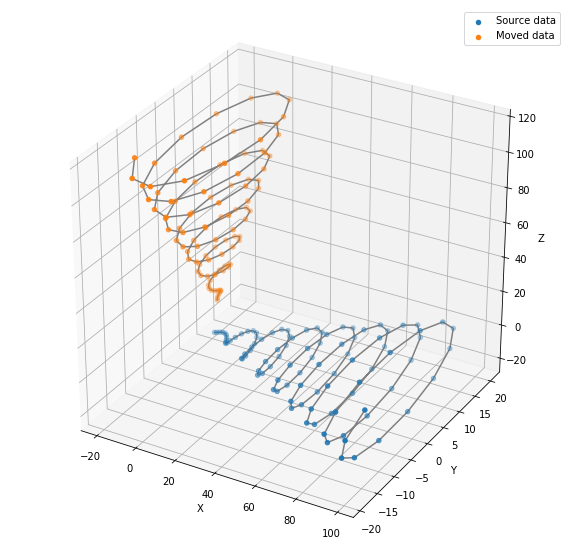

In [43]:
shift =  np.array([[-2], [2], [15]])
Xangle = 0
Yangle = pi/2
Zangle = 0
angle =  np.array([Xangle, Yangle, Zangle])
sourceData, movedData = generateSpiral(100, angle, shift)
matplotData(sourceData, movedData, "Source data", "Moved data")

#### Centre Data

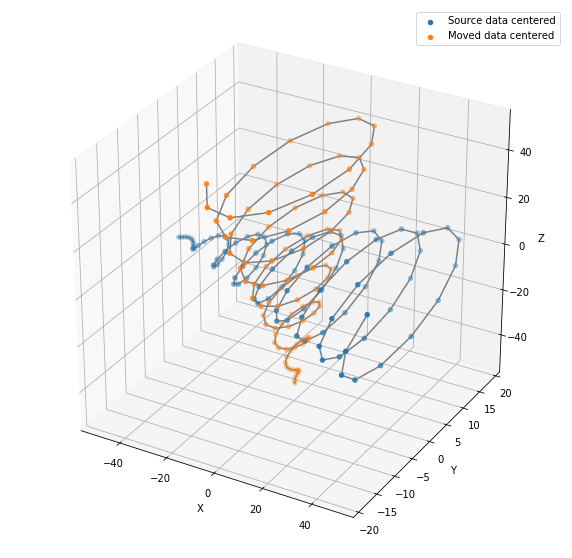

In [56]:
def centerData(data, exclude_indices=[]):
    reducedData = np.delete(data, exclude_indices, axis=1)
    center = np.array([reducedData.mean(axis = 0)])
    return center, data - center

centerMoved, movedCentered = centerData(movedData)
centerSource, sourceCentered = centerData(sourceData)
matplotData(sourceCentered, 
            movedCentered,
            'Source data centered',
            'Moved data centered')

In [57]:
def getCorrespondence(P, Q):
    """For each point in P find closest one in Q"""
    pSize = P.shape[0]
    qSize = Q.shape[0]
    correspondences = []
    for i in range(pSize):
        pPoint = P[i, :].T
        minDist = sys.maxsize
        chosenIndex = -1
        for j in range(qSize):
            qPoint = Q[j, :].T
            dist = np.linalg.norm(qPoint - pPoint)
            if dist < minDist:
                minDist = dist
                chosenIndex = j
        correspondences.append((i, chosenIndex))
    return correspondences

def drawCorrespondences(P, Q, correspondences):
    labelAdded = False
    for i, j in correspondences:
        x = [P[i, 0], Q[j, 0]]
        y = [P[i, 1], Q[j, 1]]
        z = [P[i, 2], Q[j, 2]]
        if not labelAdded:
            plt.plot(x, y, z, color='grey', label='correpondences')
            labelAdded = True
        else:
            plt.plot(x, y, z, color='grey')
    plt.legend()

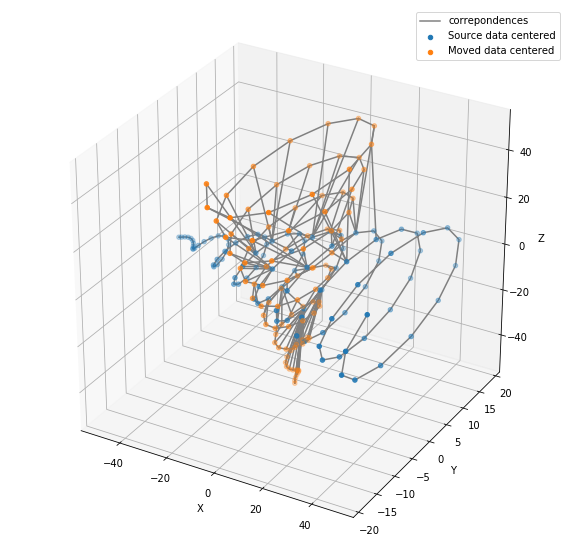

In [46]:
correspondences = getCorrespondence(movedCentered, sourceCentered)
matplotData(sourceCentered,movedCentered,
            'Source data centered',
            'Moved data centered')
drawCorrespondences(movedCentered, sourceCentered, correspondences)

#### Compute Cross Covariance

In [75]:
def computeCrosscovariance(P, Q, correspondences, kernel = lambda diff: 1.0):
    cov = np.zeros((3, 3))
    excludeIndices = []
    for i, j in correspondences:
        pPoint = P[[i], :].T
        qPoint = Q[[j], :].T
        weight = kernel(pPoint - qPoint)
        if weight < 0.01: excludeIndices.append(i)
        cov += weight * qPoint.dot(pPoint.T)
    return cov, excludeIndices

covariance, excludedIndices = computeCrosscovariance(movedCentered, sourceCentered, correspondences)
print("Covariance Matrix")
print()
print(covariance)

Covariance Matrix

[[ 6.75456543e+03 -8.64550371e+01 -4.82000000e+02]
 [-1.77325862e+01  3.13824658e+03  6.25542541e+02]
 [ 1.09896010e+03 -4.20064026e+02  2.55852877e+04]]


#### SVD Decompostion to find `R` and `t`

In [76]:
U, S, VT = np.linalg.svd(covariance)
print(S)
Rfound = U.dot(VT)
tfound = centerSource - centerMoved.dot(Rfound)
print()
print("R found :\n", Rfound)
print("t found :\n", tfound)

[25619.58613682  6770.09975238  3146.08153744]

R found :
 [[ 0.99879798 -0.00440808 -0.04881769]
 [ 0.00617282  0.99933063  0.03605812]
 [ 0.04862607 -0.03631612  0.99815662]]
t found :
 [[ 48.15175586   0.33555511 -64.72789202]]


#### Correction to P and visualization


Squared diff: (Moved Corrected - Source Centered) =  906.337285112227


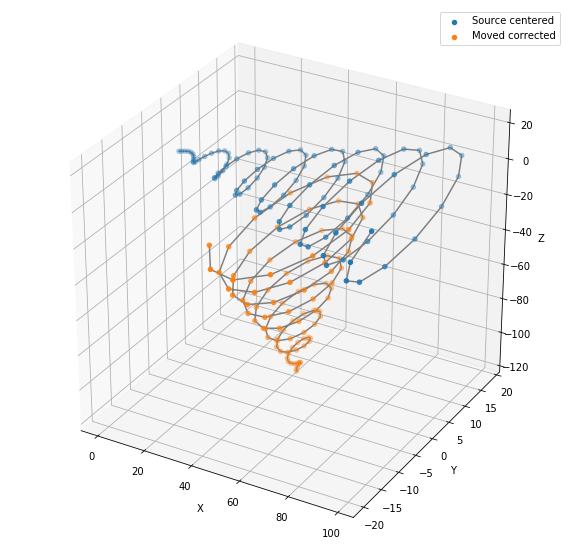

In [77]:
movedCorrected = movedCentered.dot(Rfound) + tfound
matplotData(sourceData, movedCorrected, label1='Source centered', label2='Moved corrected')
print()
print("Squared diff: (Moved Corrected - Source Centered) = ", np.linalg.norm(movedCorrected - sourceCentered))

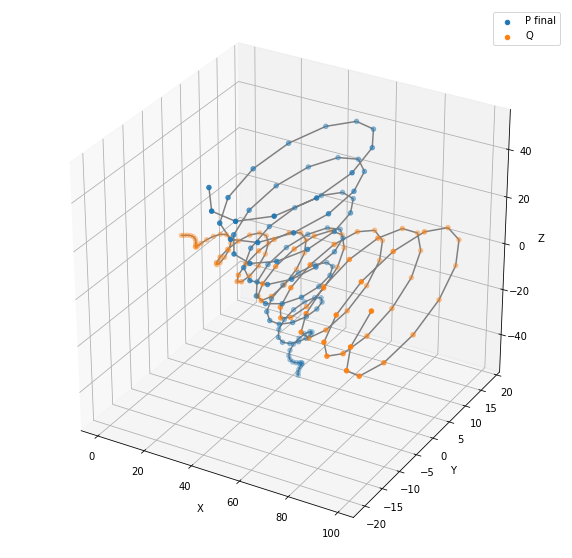

[423.5867534269704, 413.0458265194194, 413.9890981535544, 416.39931262393293, 417.80527036346376, 411.8171158517253, 423.1738703276902, 412.27355236113897, 417.6424982509071, 414.0691894131202]


In [64]:
def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD"""
    center_of_Q, Q_centered = centerData(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in range(iterations):
        center_of_P, P_centered = centerData(P_copy, exclude_indices=exclude_indices)
        correspondences = getCorrespondence(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = computeCrosscovariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)  
        t = center_of_Q - center_of_P.dot(R)  
        P_copy = P_copy.dot(R) + t
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values

P_values, norm_values, corresp_values = icp_svd(movedData, sourceData)
# plot_values(norm_values, label="Squared diff P->Q")
matplotData(P_values[-1], sourceData, label1='P final', label2='Q')
plt.show()
print(norm_values)